In [2]:
import pandas as pd 
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import time
import cv2
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, f1_score,cohen_kappa_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.ensemble import AdaBoostClassifier

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.porter import PorterStemmer

In [3]:
import numpy as np
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df= pd.read_csv('test.csv')


# Overview of the Dataset

In [4]:
train_df.head(5)

,Type,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Fee,Description,AdoptionSpeed,Images,Breed
0,Dog,84.0,Male,Brown,Cream,Unknown,Small,No,Unknown,Yes,No,Healthy,0.0,He is either lost or abandoned. Please contact...,4.0,3b178aa59-5.jpg,Terrier
1,Dog,1.0,Female,Black,Unknown,Unknown,Medium,Yes,No,Yes,No,Healthy,50.0,"Hi, my name is Rose. I'm very friendly and am ...",3.0,2fbf2cb7c-1.jpg,Mixed_Breed
2,Dog,1.0,Male,Brown,Unknown,Unknown,Medium,Yes,No,No,No,Healthy,0.0,Puppy's age is unknown. My husband went mounta...,1.0,97f683e04-1.jpg,Mixed_Breed
3,Dog,3.0,Male,Black,Unknown,Unknown,Medium,Yes,Unknown,Yes,Unknown,Healthy,0.0,"Hi, I'm Randy, few weeks ago I got beaten by h...",4.0,479500716-2.jpg,Mixed_Breed
4,Dog,8.0,Male,Brown,Unknown,Unknown,Large,Yes,Yes,Yes,No,Healthy,0.0,"Abandoned puppy looking for a home. Hi, he is ...",3.0,4a2270c3e-4.jpg,Mixed_Breed


In [5]:
test_df.head(5)

,Type,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Fee,Description,Images,Breed
0,Cat,1.0,Male,Black,White,Unknown,Small,Yes,No,No,No,Healthy,0.0,"kitten for adoption, pls call for enquiry, off...",5df99d229-2.jpg,Domestic_Short_Hair
1,Dog,8.0,Male,Black,Brown,Unknown,Medium,Yes,No,No,No,Healthy,0.0,"Stray puppy that came to my house. Obedient, w...",a08030c6f-2.jpg,Mixed_Breed
2,Dog,2.0,Female,Brown,Cream,White,Medium,Unknown,Yes,Yes,No,Healthy,0.0,A kind person rescued her in an abandoned buil...,c8c3eb092-1.jpg,Mixed_Breed
3,Dog,3.0,Female,Black,Brown,Unknown,Medium,Yes,Yes,Yes,No,Healthy,0.0,"Sweety as her name says is a sweet , fun and c...",56e91b142-1.jpg,Mixed_Breed
4,Cat,3.0,Female,Brown,Cream,White,Medium,Yes,No,No,No,Healthy,10.0,3 months old kitten for adoption. Female and p...,094636517-1.jpg,Domestic_Short_Hair


# Exploring and Cleaning Dataset

In [6]:
# Checking the type of animals given in the dataset
train_df['Type'].value_counts()

Type
Dog    5380
Cat    3620
Name: count, dtype: int64

# checking the datatypes of the columns in train and test dataset

In [7]:
train_df.dtypes

Type              object
Age              float64
Gender            object
Color1            object
Color2            object
Color3            object
MaturitySize      object
FurLength         object
Vaccinated        object
Dewormed          object
Sterilized        object
Health            object
Fee              float64
Description       object
AdoptionSpeed    float64
Images            object
Breed             object
dtype: object

In [8]:
test_df.dtypes

Type             object
Age             float64
Gender           object
Color1           object
Color2           object
Color3           object
MaturitySize     object
FurLength        object
Vaccinated       object
Dewormed         object
Sterilized       object
Health           object
Fee             float64
Description      object
Images           object
Breed            object
dtype: object

# checking missing values in train and test dataset

In [9]:
missing_values_train =train_df.isnull().sum()
missing_values_train

Type             0
Age              0
Gender           0
Color1           0
Color2           0
Color3           0
MaturitySize     0
FurLength        0
Vaccinated       0
Dewormed         0
Sterilized       0
Health           0
Fee              0
Description      0
AdoptionSpeed    0
Images           0
Breed            0
dtype: int64

In [10]:
missing_values_test= test_df.isnull().sum()
missing_values_test

Type            0
Age             0
Gender          0
Color1          0
Color2          0
Color3          0
MaturitySize    0
FurLength       0
Vaccinated      0
Dewormed        0
Sterilized      0
Health          0
Fee             0
Description     0
Images          0
Breed           0
dtype: int64

# Age Column

> We can see that Age is not normalized and scales of measuring the ages of Dogs and Cats are different, in order to make them standardized, I'll be converting this ages to Human Age's via transformers as we can then have a common measuring scale

> Age is very important column according to me as people tend to buy more younger pets then the older one

In [11]:
Cat_age = train_df.loc[train_df['Type']== 'Cat','Age'].unique()
Dog_age= train_df.loc[train_df['Type']== 'Dog','Age'].unique()

print('\n Cat unique Age',Cat_age)
print('\n Dogs unique Age',Dog_age)


 Cat unique Age [  4.   1.   2.  12.  16.   5.   3.   9.   6.  18.  48.  10.   8.  36.
  15.   7.   0.  24.  14.  72.  84.  30.  11.  17.  29.  19.  22.  34.
  20.  38.  31.  21.  27.  80.  13.  60. 212.  40.  42.  28.  61. 120.
  54.  23. 144.  25.  51.  26.  96.  41.  39. 108. 112.  67.  47.  62.
 147.  92. 132.  73.  44. 180.  32.  33.  55.  46.]

 Dogs unique Age [ 84.   1.   3.   8.  24.  12.  18.  36.   2.  10.   4.   6.  60.   5.
  48.  53.  29. 120.  42.  28.  30.  72.  96.   7.  20.   0.  15.  16.
  17.   9.  11.  19.  22.  13.  14.  63.  62.  21. 180.  31. 156. 108.
  41.  27.  52.  32.  78.  50.  46.  26.  33.  61.  54.  35.  51.  91.
  87.  49.  89.  55.  77.  81.  85.  38.  80. 122.  39.  25.  45.  76.
 144.  65.  66. 255.  67.  68. 117. 102.  37.  82.  23.  86.  74. 112.
  64.  95.  56. 168. 132.  75.  34.  73. 212.  57.]


> In order to have an Overview of the Dataset I'll be printing the unique values of each column

In [12]:
for column in train_df.columns:
    unique_values= train_df[column].unique()
    print(f'Unique values in {column}: {unique_values}')

Unique values in Type: ['Dog' 'Cat']
Unique values in Age: [ 84.   1.   3.   8.  24.  12.  18.  36.   4.   2.  10.  16.   5.   9.
   6.  60.  48.  53.  29. 120.  42.  28.  30.  15.  72.   7.  96.   0.
  20.  14.  17.  11.  19.  22.  13.  63.  62.  21. 180.  31. 156. 108.
  34.  41.  27.  52.  32.  38.  78.  50.  46.  80.  26.  33. 212.  61.
  54.  40.  35.  51.  91.  87.  49.  89.  55.  77.  81.  85. 122.  39.
  25.  23.  45. 144.  76.  65.  66. 255. 112.  67.  68. 117. 102.  37.
  82.  47. 147.  92.  86. 132.  74.  73.  44.  64.  95.  56. 168.  75.
  57.]
Unique values in Gender: ['Male' 'Female']
Unique values in Color1: ['Brown' 'Black' 'Golden' 'White' 'Cream' 'Yellow' 'Gray']
Unique values in Color2: ['Cream' 'Unknown' 'White' 'Golden' 'Gray' 'Brown' 'Yellow']
Unique values in Color3: ['Unknown' 'White' 'Golden' 'Gray' 'Cream' 'Yellow']
Unique values in MaturitySize: ['Small' 'Medium' 'Large' 'Extra Large']
Unique values in FurLength: ['No' 'Yes' 'Unknown']
Unique values in Vaccin

In [13]:
#checking for duplicacy in the Images column as images are named after the Pet ID's
train_df['Images'].duplicated().any()

False

> Categorizing the columns into numerical, categorical, text and images

In [14]:
num_col = train_df.select_dtypes(include=['float64']).columns.tolist()  # Numeric columns
cat_col = train_df.select_dtypes(include=['object']).drop(columns=['Images', 'Description']).columns.tolist() #categorical columns except images and text
text_col=['Description']
img_col=['Images']
print('Numerical columns :',num_col)
print("\nCategorical columns :",cat_col)
print("\nText columns :",text_col)
print("\nImages columns :",img_col)

Numerical columns : ['Age', 'Fee', 'AdoptionSpeed']

Categorical columns : ['Type', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Breed']

Text columns : ['Description']

Images columns : ['Images']


# Correlation 

> Need to findout correlation between the Numerical features and target column.

> Even though "Age" and "Fee" have very less correlation with the target variable "Adoption Speed", I think they should not be deleted as they play very important role in predicting the Adoptionrate as to me it makes sense that person will adopt pet, if its younger and fees is less.

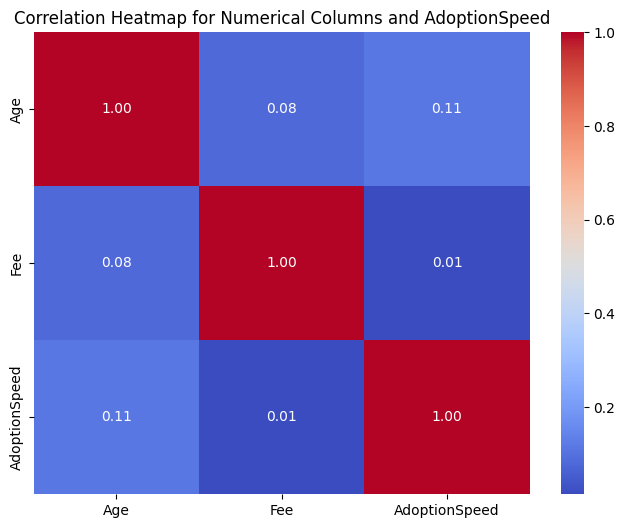

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numerical_df = train_df[num_col]
corr_matrix = numerical_df.corr().abs()

# Plotting heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.title('Correlation Heatmap for Numerical Columns and AdoptionSpeed')
plt.show()

> Loading the Images into the Train and Test Dataset

In [16]:
train_df.shape

(9000, 17)

# Adding the Images to Dataset

In [17]:
img_dir = "/Users/ashwinichoudhary/Downloads/Adoption_2024/train_images/"
test_img_dir = "/Users/ashwinichoudhary/Downloads/Adoption_2024/test_images/"
train_df['Images'] = [img_dir+img for img in train_df['Images']]
test_df['Images']= [test_img_dir + img for img in test_df['Images']]

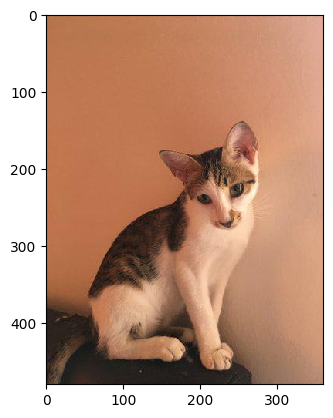

In [18]:

from matplotlib.image import imread
train_df['Images'][8]
img = imread(train_df['Images'][9])
plt.imshow(img, cmap='gray', interpolation='nearest', aspect='equal')

 ## columns which are categorized into 4 categories as mentioned below:
 

> **Numerical columns:** ['Age', 'Fee', 'AdoptionSpeed']

> **Categorical columns:** ['Type', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Breed']

> **Text columns:** ['Description']

> **Images columns:** ['Images']


# Preprocessing of the Data

> **HANDLING TEXT DATA**

**STEP1:** Remove the EMOJIS

**STEP2:** Lower case the texts

**STEP3:** Remove the puntuations

**STEP4:** Remove the Stop words

**STEP5:** Lemmatize the text



In [19]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.porter import PorterStemmer

# Regex

> Here I used the Regex pattern library so that I can input as many possibilites to remove the emojis and there kind.

In [20]:
# Function to remove emojis

import re

def remove_emojis(text):
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               u"\U0001F910-\U0001F97A"
                               u"\U0001F980-\U0001F9B0"
                               u"\U0001F9C0-\U0001F9FF"
                               u"\U0001FA60-\U0001FA6F"
                               u"\U0001FA70-\U0001FAFF"
                               u"\U00002600-\U000026FF"  # Miscellaneous Symbols
                               u"\U00002700-\U000027BF"  # Dingbats
                               u"\U00002B50"
                               u"\U000023E9-\U000023FA"  # Miscellaneous Technical
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text) #It was replace emojis with the empty string


# NLTK

> I used NLTK English for Stop words 

In [21]:
#function to remove stop words

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    
    return ' '.join(filtered_text)

# Punctuations

> Remove the Puntuations

In [22]:
import re
import string

# Function to remove puntuations

def remove_punctuation(text):
    
    punctuation_pattern = re.compile('[%s]' % re.escape(string.punctuation))

    return punctuation_pattern.sub('', text)


# Lemmatizer

In [23]:
word_lemmatizer=  WordNetLemmatizer()

# Final Function to integrate all the text preprocessing 

def cleaned_text(text):
    text= remove_emojis(text)
    text= text.lower()
    text= remove_stop_words(text)
    text= remove_punctuation(text)
    text= word_lemmatizer.lemmatize(text)
    return text

## MyTextTransformer()

> In order to merge all the functions and to apply **CountVectorizer()** I build my own custom Transformer, Also it will ease my process when I'll apply Random Search on it.

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer


class MyTextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        
        self.cv = CountVectorizer()
    
    def fit(self, X, y=None):
        
        cleaned_texts = self._clean(X)
        
        self.cv.fit(cleaned_texts)
        return self
    
    def transform(self, X, y=None):
        
        cleaned_texts = self._clean(X)
        
        return self.cv.transform(cleaned_texts)
    
    def fit_transform(self, X, y=None):
        return super().fit_transform(X, y)
    
    def _clean(self, texts):
        
        cleaned_texts = [cleaned_text(text) for text in texts]
        return cleaned_texts


# Age Column Preprocessing - AgeConverter()

> Here I made a custom transformer for the Age column in order to convert it into human age, I chose human age because I saw in the dataset tha parameters for age calculation for dogs and cat were different.So I order to have same calculating scale I chose to go with there respective human age.

> Age is very important column as per my understanding in order to adopt pets as people tend to buy younger pets.

> **Source: https://www.petsplusus.com/pet-information/health/age-calculator**

> Here I'll divide the age of Cat's by (5) and Dog's by (7)

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

class AgeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, cat_scale=5, dog_scale=7):
        
        self.cat_scale = cat_scale
        self.dog_scale = dog_scale
    
    def fit(self, X, y=None):

        return self
    
    def transform(self, X):
        
        X_transformed = X.copy()
        
        # Apply the age conversion for cats
        X_transformed.loc[X_transformed['Type'] == 'Cat', 'Age'] = \
            X_transformed.loc[X_transformed['Type'] == 'Cat', 'Age'] / self.cat_scale
        
        # Apply the age conversion for dogs
        X_transformed.loc[X_transformed['Type'] == 'Dog', 'Age'] = \
            X_transformed.loc[X_transformed['Type'] == 'Dog', 'Age'] / self.dog_scale
        
        return X_transformed

# Handling Images

> **The base structure of the image handling functions was given by the professor I just had to fill them.**

**Functions given by professor:**

> `extract_SIFT` :

**1. Load Images:** The function reads each image from the provided list of image paths using OpenCV's cv2.imread function.

**2. Convert to Gray Scale:** Each loaded image is converted to grayscale with cv2.cvtColor and the cv2.COLOR_BGR2GRAY flag, preparing it for feature detection.

**3. Extract SIFT (Scale-Invariant Feature Transform) Keypoints and Descriptors:** Initializes a SIFT detector using cv2.xfeatures2d.SIFT_create(), then applies it to each grayscale image to find keypoints and compute their descriptors.

**4. Return the SIFT List:** Compiles and returns a list of descriptors for each image. Each element in the returned list corresponds to the SIFT descriptors of an image, facilitating further image analysis or matching tasks.

> `clusterize` :
 
 **1. Stack the SIFT Features:** The function stacks the SIFT descriptors (features) from multiple images into a single array using np.vstack(SIFs), preparing them for clustering.

**2. Create the KMeans Clusterizer:** Initializes a KMeans clustering model with the specified number of clusters (nb_cluster) using KMeans(n_clusters=nb_cluster) from scikit-learn.

**3. Fit the Clusterizer with the SIFT Features:** The KMeans model is fitted to the stacked SIFT features to identify clusters among the features. This process partitions the features into nb_cluster distinct clusters based on their similarity.

**4. Return the Clusterizer:** The function returns the fitted KMeans clusterizer object, which includes information about the clusters such as the cluster centers. This object can be used for further analysis or assigning new features to the identified clusters.


> `build_BOFs` :

**1. Initialize BOF Matrix:** Creates a zero matrix for the Bag of Features (BOF) representation, sized by the number of SIFT descriptor lists and the number of clusters in clusterizer.

**2. Predict Cluster Labels:** Iterates over SIFT descriptor lists, using clusterizer to predict cluster labels for each descriptor.

**3. Create and Normalize Histograms:** Generates a normalized histogram of cluster occurrences for each SIFT list, ensuring it sums to 1.

**4. Return BOF Representation:** Outputs the matrix where each row is the BOF representation of an image's SIFT features, suitable for further analysis.


>  `MyImageTransformer` :

**1. Initialization:** Sets the number of clusters for KMeans clustering of SIFT features.

**2. Fit:** Extracts SIFT features from images, then fits a KMeans model to these features.

**3. Transform:** Converts new images to their BOF representations using the fitted model.

**4. Fit_transform:** Combines fit and transform steps to directly produce BOF representations from input images, ready for machine learning applications.

In [26]:
import cv2

def extract_SIFT(img_lst):
    sift = sift = cv2.SIFT_create()
    sift_lst = []
    for img in img_lst:
        img=cv2.imread(img) 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        kp, des = sift.detectAndCompute(gray, None)
        sift_lst.append(des)
    
    return sift_lst

In [27]:
from sklearn.cluster import KMeans

def clusterize(SIFs, nb_cluster):
    sift_features = np.vstack(SIFs)
    clusterizer = KMeans(n_clusters=nb_cluster)
    clusterizer.fit(sift_features)
    return clusterizer


In [28]:
def build_BOFs(SIFTs, clusterizer):
  
    bof_representation = np.zeros((len(SIFTs), clusterizer.n_clusters), dtype=np.float32)
    
    
    for i, sift in enumerate(SIFTs):
        cluster_labels = clusterizer.predict(sift) 
        histogram = np.bincount(cluster_labels, minlength=clusterizer.n_clusters) 
        histogram = histogram / histogram.sum() 
        bof_representation[i, :] = histogram
    
    return bof_representation

In [29]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin


class MyImageTransformer(BaseEstimator,TransformerMixin): 
    def __init__(self, nb_cluster=4):
        self.nb_cluster=4

    def fit(self, X, y=None): 
        self.SIFTs = extract_SIFT(X)
        self.clusterizer = clusterize(SIFTs, self.nb_cluster)
        
    def transform(self, X, y=None): 
        self.SIFTs = extract_SIFT(X)
        return build_BOFs(self.SIFTs, self.clusterizer)
    
    def fit_transform(self, X, y=None): 
        self.SIFTs = extract_SIFT(X)
        self.clusterizer = clusterize(self.SIFTs, self.nb_cluster)
        return build_BOFs(self.SIFTs, self.clusterizer)
    

# Handling Imbalance Data

> As I can see that class 0 has very less values comparing other classes so I need to oversample the class.

In [30]:
df_train_X = train_df.drop(['AdoptionSpeed'], axis = 1)
df_train_y= train_df['AdoptionSpeed']

df_train_y.value_counts()

AdoptionSpeed
2.0    2504
4.0    2294
3.0    2061
1.0    1894
0.0     247
Name: count, dtype: int64

#  Splitting data and OverSampling

 ## Splitting was neccessary otherwise I would have faced the problem of data leakage

> Here since we are using direct approach so I directly used **resample** module from sklearn instead of SMOTE

> I kept the test size as 0.1 because I want more data in the training and I want to lose as much as less possible.

In [31]:
from sklearn.model_selection import train_test_split
X_train_bf_sampling,X_val_bf_sampling,y_train_bf_sampling, y_val_bf_sampling= train_test_split(df_train_X,df_train_y,random_state=42,test_size=0.1)

In [32]:
# minority and majority classes in y_train
from sklearn.utils import resample

df_train_split = pd.concat([X_train_bf_sampling, y_train_bf_sampling], axis=1)
df_majority = df_train_split[df_train_split.AdoptionSpeed != 0]
df_minority = df_train_split[df_train_split.AdoptionSpeed == 0]

# Oversampling the minority class
df_minority_oversampled = resample(df_minority,
                                   replace=True,
                                   n_samples=1800,  # Example to balance with the majority class
                                   random_state=123)

# Concatenating the resampled minority class with the majority class
df_oversampled = pd.concat([df_majority, df_minority_oversampled])

In [33]:
df_oversampled["AdoptionSpeed"].value_counts()

AdoptionSpeed
2.0    2261
4.0    2049
3.0    1851
0.0    1800
1.0    1711
Name: count, dtype: int64

In [34]:

X_test=test_df.copy()

X_train = df_oversampled.drop(['AdoptionSpeed'], axis = 1)

y_train = np.array(df_oversampled['AdoptionSpeed']).reshape((-1,1))


In [35]:
print('shape of X_train: ',X_train.shape)
print('shape of y_train: ',y_train.shape)

print('shape of X_test: ',X_test.shape)


shape of X_train:  (9672, 16)
shape of y_train:  (9672, 1)
shape of X_test:  (500, 16)


# Function for Metrics

In [36]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, f1_score,cohen_kappa_score


kappa_score = make_scorer(cohen_kappa_score, weights='quadratic')

**Source**: https://scikit-learn.org/stable/

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay
def getMetrics(y_train,y_pred):
    y_pred=y_pred.astype(int)
    mse_train = mean_squared_error(y_train, y_pred)
    acc_train = accuracy_score(y_train, y_pred)
    kappa_train=cohen_kappa_score(y_train,y_pred,weights="quadratic")
    train=[['Train',mse_train,acc_train,kappa_train]]
    metrics=['Dataset','MSE','Acc','Kappa']
    df = pd.DataFrame(train, columns=metrics) 
    return df,ConfusionMatrixDisplay.from_predictions(y_train, y_pred.astype(int), cmap="Blues")

# Reducing Dataframe for Cross Validation

> Here I took exactly 800 samples of each class in order to perform cross validation and get the best parameters, Getting best parameters with all the 9000 samples was very time consuming so I took 800 samples.


In [37]:
from sklearn.utils import resample

n_samples = 800
resampled_dfs = []

for class_value in df_oversampled['AdoptionSpeed'].unique():
    df_class = df_oversampled[df_oversampled.AdoptionSpeed == class_value]
    

    df_class_resampled = resample(df_class, 
                                  replace=len(df_class) < n_samples,
                                  n_samples=n_samples, 
                                  random_state=123)
    
    
    resampled_dfs.append(df_class_resampled)

df_balanced = pd.concat(resampled_dfs)

print(df_balanced['AdoptionSpeed'].value_counts())

AdoptionSpeed
1.0    800
4.0    800
2.0    800
3.0    800
0.0    800
Name: count, dtype: int64


In [38]:
df_balanced.shape

(4000, 17)

In [39]:
X_train_balanced= df_balanced.drop(['AdoptionSpeed'], axis = 1)
y_train_balanced = np.array(df_balanced['AdoptionSpeed']).reshape((-1,1))

In [40]:
X_train_balanced.shape
y_train_balanced.shape

(4000, 1)

# Cross Validation Function - CrossVal()

> I used made a function for cross validation as I'll be performing this on many models, and I can call the function it will make my task easy.



In [1]:
# here I removed 'AdoptionSpeed' from the num_col as its the target variable and it will be stored in y_train

num_col = ['Age', 'Fee']
cat_col = ['Type', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Breed']
text_cols = ['Description'] 
img_cols=['Images']

In [42]:


def CrossVal(model, classifier_param_distributions, n_iter=100):
    start_time = time.time()

    pipeline = Pipeline(steps=[
        ('age', AgeConverter()), 
        ("transform", ColumnTransformer(transformers=[
            ('numeric', MinMaxScaler(), num_col),
            ('categorical', OneHotEncoder(handle_unknown='ignore'), cat_col),
            ('image', MyImageTransformer(), 'Images'), #passing string as my function accepts string instead of a list.
            ('text', MyTextTransformer(), 'Description') #here also passing string instead of list.
        ])),
        ('clf', model)
    ])
    
    # random search cv
    random_search = RandomizedSearchCV(pipeline, classifier_param_distributions, n_iter=n_iter, cv=5, verbose=3, scoring=kappa_score, random_state=42)

    random_search.fit(X_train_balanced, np.array(y_train_balanced).ravel())
    print("--- Random Search Execution : %s seconds ---" % (time.time() - start_time))
    return random_search


# Random Forest Classifier Parameters grid

> Here I made combination of hyperparameters for randomforest I took help of sklearn documentation to do it.

> **Source:** https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
forest_param_grid = [
        {
            'transform__numeric':[MinMaxScaler()],
            'transform__numeric__feature_range': [(0, 1), (-1, 1)],
            'transform__categorical':[OneHotEncoder(handle_unknown='ignore')],
            'clf__n_estimators': [10, 100, 1000],
            'clf__max_depth': [None, 5, 10,100]
        },
         {
             'transform__numeric':[StandardScaler()],
             'transform__numeric__copy': [True,False],
             'transform__categorical':[OneHotEncoder(handle_unknown='ignore')],
             'clf__n_estimators': [10, 100,1000],
             'clf__max_depth': [None,5, 10,100]
         },
        {
            'transform__numeric':[MinMaxScaler()],
            'transform__numeric__feature_range': [(0, 1), (-1, 1)],
            'transform__categorical':[CountVectorizer()],
            'clf__n_estimators': [10, 100, 1000],
            'clf__max_depth': [None, 5, 10,100]
        },
         {
             'transform__numeric':[StandardScaler()],
             'transform__numeric__copy': [True,False],
             'transform__categorical':[CountVectorizer()],
             'clf__n_estimators': [10, 100,1000],
             'clf__max_depth': [None,5, 10,100]
         }
    ]

RandomForestGrid=CrossVal(RandomForestClassifier(),forest_param_grid)


# Best parameters and score for Randomforest algorithm

In [44]:
print("Best Parameters: ",RandomForestGrid.best_params_)
print("Best Score: ",RandomForestGrid.best_score_)

Best Parameters:  {'transform__numeric__copy': True, 'transform__numeric': StandardScaler(), 'transform__categorical': OneHotEncoder(handle_unknown='ignore'), 'clf__n_estimators': 1000, 'clf__max_depth': None}
Best Score:  0.6357044571262562


#  Logistic Regression parameter grid

> **Source:** https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:


Logistic_reg_grid=[

        {
            'transform__numeric':[MinMaxScaler()],
            'transform__numeric__feature_range': [(0, 1), (-1, 1)],
            'transform__categorical':[OneHotEncoder(handle_unknown='ignore')],
            'clf__C': [1, 10, 100, 1000],
            'clf__fit_intercept': [True, False],
            'clf__solver':['newton-cg','sag','saga','lbfgs']

        },
         {
            'transform__numeric':[StandardScaler()],
            'transform__numeric__copy': [True,False],
            'transform__categorical':[OneHotEncoder(handle_unknown='ignore')],
            'clf__C': [1, 10, 100, 1000],
            'clf__fit_intercept': [True, False],
            'clf__solver':['newton-cg','sag','saga','lbfgs']
         },
        
    ]

logistic_parameters=CrossVal(LogisticRegression(max_iter=10000),Logistic_reg_grid)


# Best parameters and score for Logistic Regression

In [42]:
print("Best Parameters: ",logistic_parameters.best_params_)
print("Best Score: ",logistic_parameters.best_score_)

Best Parameters:  {'transform__numeric__feature_range': (-1, 1), 'transform__numeric': MinMaxScaler(feature_range=(-1, 1)), 'transform__categorical': OneHotEncoder(handle_unknown='ignore'), 'clf__solver': 'saga', 'clf__fit_intercept': True, 'clf__C': 1}
Best Score:  0.5349897650203409


# Naive Bayes parameters grid

> **Source:** https://scikit-learn.org/stable/modules/naive_bayes.html

>**Note:** I did not used Standard Scaler as it produces some negative values and naive bayes does not accept it, it strictly works on positive values.

In [ ]:
naive_bayes_param_grid=[{
            'transform__numeric__feature_range': [(0, 1)],
            'clf__alpha': [0.1, 0.5, 1.0, 2.0]
        },
        {
            'transform__numeric':[MinMaxScaler()],
            'transform__numeric__feature_range': [(0, 1)], # I made range here 0 to 1 as naive bayes donot take negative values
            'transform__categorical':[OneHotEncoder(handle_unknown='ignore')],
            'clf__alpha': [0.1, 0.5, 1.0, 2.0]
        },
         {  'transform__numeric':[MinMaxScaler()], 
            'transform__numeric__feature_range': [(0, 1)],
            'transform__categorical':[CountVectorizer()],
            'clf__alpha': [0.1, 0.5, 1.0, 2.0]

         }]


naive_bayes_parameters= CrossVal(MultinomialNB(),naive_bayes_param_grid)

# Naive Bayes Best parameters and score

In [44]:
print("Best Parameters: ",naive_bayes_parameters.best_params_)
print("Best Score: ",naive_bayes_parameters.best_score_)

Best Parameters:  {'transform__numeric__feature_range': (0, 1), 'clf__alpha': 0.1}
Best Score:  0.4864053666361599


# Boosting parameter grid

**Source:** https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html


In [ ]:
boosting_param_grid=[{
            'transform__numeric':[MinMaxScaler()],
            'transform__numeric__feature_range': [(0, 1), (-1, 1)],
            'transform__categorical':[OneHotEncoder(handle_unknown='ignore')],
            'clf__n_estimators': [50, 100, 200],
            'clf__max_depth': [3, 5, 7],
            'clf__subsample': [0.5, 0.75, 1.0],        
            'clf__loss':['log_loss','deviance','exponential'],
            'clf__learning_rate': [0.01, 0.1, 0.5]    },
         {
            'transform__numeric':[StandardScaler()],
            'transform__numeric__copy': [True,False],
            'transform__categorical':[OneHotEncoder(handle_unknown='ignore')],
            'clf__n_estimators': [50, 100, 200],
            'clf__max_depth': [3, 5, 7],
            'clf__subsample': [0.5, 0.75, 1.0],        
            'clf__loss':['log_loss','deviance','exponential'],
            'clf__learning_rate': [0.01, 0.1, 0.5]     
            }]

Boosting_best_parameters=CrossVal(GradientBoostingClassifier(),boosting_param_grid)

# Boosting Best Parameters

In [43]:
print("Best Parameters: ",Boosting_best_parameters.best_params_)
print("Best Score: ",Boosting_best_parameters.best_score_)

Best Parameters:  {'transform__numeric__copy': True, 'transform__numeric': StandardScaler(), 'transform__categorical': OneHotEncoder(handle_unknown='ignore'), 'clf__subsample': 0.5, 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__loss': 'log_loss', 'clf__learning_rate': 0.1}
Best Score:  0.6028789198242098


# Fitting pipelines of models with Best parameters

In [35]:
from sklearn.model_selection import train_test_split
X_train_new, X_validation, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# Logistic Regression with Best parameters

## Explanation for choosing the parameters:

> `fit_intercept`: there's no need for the model to calculate the intercept. This is beneficial because my features are already scaled or normalized, so my algorithm will have one less parameter to train.

> `solver`: As I wanted my crossvalidation should include solver so that I know that what will be the best solver for my complex data.

>  `max_iter`: I defoined explicitly to 10000 so that algorithm gets sufficient iterations to converge the optimizer `lbfgs`.

> `MinMaxScaler`: To normalize the numerical data I needed it and feature range was fount out using the crossvalidation.

In [51]:
logistic_reg_images=LogisticRegression(fit_intercept=False,C=10,solver='lbfgs',max_iter=10000)

logistic_reg_Pipeline=Pipeline(steps=[
        
        ('age',AgeConverter()), 
        ("transform",ColumnTransformer(transformers=[
            ('numeric',MinMaxScaler(feature_range=(-1, 1)),num_col),
            ('categorical',OneHotEncoder(handle_unknown='ignore'),cat_col),
            ('image',MyImageTransformer(),'Images'),
            ('text',MyTextTransformer(),'Description')
        ])),
        ('clf',logistic_reg_images)
    ])

logistic_reg_Pipeline.fit(X_train_new, np.array(y_train_new).ravel()) 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('age', AgeConverter()),
                ('transform',
                 ColumnTransformer(transformers=[('numeric',
                                                  MinMaxScaler(feature_range=(-1,
                                                                              1)),
                                                  ['Age', 'Fee']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Type', 'Gender', 'Color1',
                                                   'Color2', 'Color3',
                                                   'MaturitySize', 'FurLength',
                                                   'Vaccinated', 'Dewormed',
                                                   'Sterilized', 'Health',
                                                   'Breed']),
                                                 ('image', MyImageTransformer(),
                                                  'Images'),
                                                 ('text', MyTextTransformer(),
                                                  'Description')])),
                ('clf',
                 LogisticRegression(C=10, fit_intercept=False,
                                    max_iter=10000))])

> Predictions on X_validation to get the kappa score

(  Dataset       MSE       Acc     Kappa
 0   Train  1.688299  0.473709  0.575269,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x290e36710>)

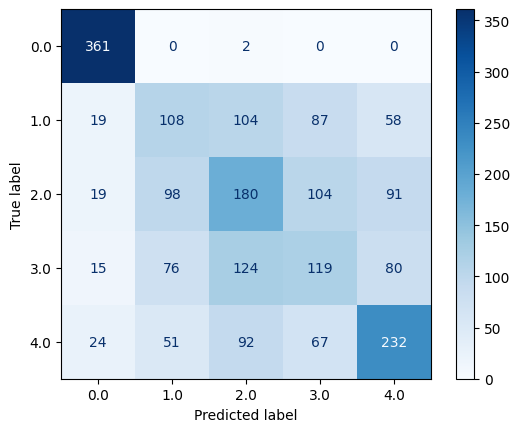

In [52]:
logistic_reg_pred=logistic_reg_Pipeline.predict(X_validation)
getMetrics(y_val,logistic_reg_pred)

# Naive bayes pipeline with best parameter

## Explanation for choosing these parameters:

> `alpha`: I chose alpha as one parameter as it provides smoothening to the discrete data and handle the problem of zero probabilities.

> `MinMaxscaler`: here I chose `MinMaxScaler` instead of `StandardScaler` because StandardScaler takes negative values into account which is not possible for Naive bayes to calculate, hence I used MinMaxScaler and mentioning range from 0 to 1.

In [64]:
naive_bayes_image=MultinomialNB(alpha=0.1)

naive_bayes_pipeline=Pipeline(steps=[
        
        ('age',AgeConverter()), 
        ("transform",ColumnTransformer(transformers=[
            ('numeric',MinMaxScaler(feature_range=(0, 1)),num_col),
            ('categorical',OneHotEncoder(handle_unknown='ignore'),cat_col),
            ('image',MyImageTransformer(),'Images'),
            ('text',MyTextTransformer(),'Description')
        ])),
        ('clf',naive_bayes_image)
    ])

naive_bayes_pipeline.fit(X_train_new, np.array(y_train_new).ravel())


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('age', AgeConverter()),
                ('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  ['Age', 'Fee']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Type', 'Gender', 'Color1',
                                                   'Color2', 'Color3',
                                                   'MaturitySize', 'FurLength',
                                                   'Vaccinated', 'Dewormed',
                                                   'Sterilized', 'Health',
                                                   'Breed']),
                                                 ('image', MyImageTransformer(),
                                                  'Images'),
                                                 ('text', MyTextTransformer(),
                                                  'Description')])),
                ('clf', MultinomialNB(alpha=0.1))])

(  Dataset       MSE      Acc     Kappa
 0   Train  1.952155  0.44576  0.518011,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x14bca7650>)

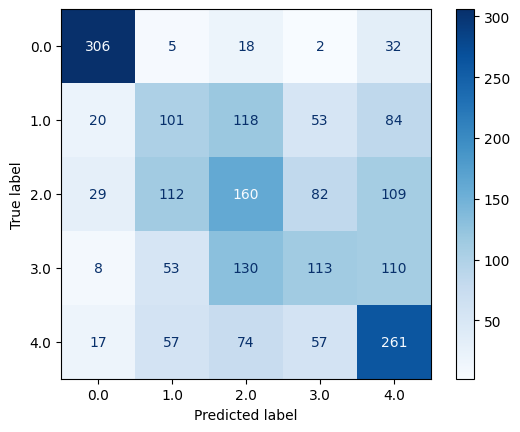

In [65]:
naive_bayes_pred=naive_bayes_pipeline.predict(X_validation)
getMetrics(y_val,naive_bayes_pred)

# Random forest pipeline with best parameters

## Explanation for these parameters:

> `n_estimators`: I chose these parameter in order to get the number of tress required for the algorithm to produce the results.This parameter helps us to get more accuracy.

> `max_depth` : This paramter ensures that value of leaf nodes keeps growing until we get the pure value,which will help in the voting process for classification.


In [59]:
random_forest_image=RandomForestClassifier(n_estimators=1000,max_depth=None)

random_forest_Pipeline=Pipeline(steps=[
        
        ('age',AgeConverter()),
        ("normalizer",ColumnTransformer(transformers=[
            ('numeric',MinMaxScaler(feature_range=(0,1)),num_col),
            ('categorical',OneHotEncoder(handle_unknown='ignore'),cat_col),
            ('image',MyImageTransformer(),'Images'),
            ('text',MyTextTransformer(),'Description')
        ])),
        ('clf',random_forest_image)
    ])

random_forest_Pipeline.fit(X_train_new, np.array(y_train_new).ravel())



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('age', AgeConverter()),
                ('normalizer',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  ['Age', 'Fee']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Type', 'Gender', 'Color1',
                                                   'Color2', 'Color3',
                                                   'MaturitySize', 'FurLength',
                                                   'Vaccinated', 'Dewormed',
                                                   'Sterilized', 'Health',
                                                   'Breed']),
                                                 ('image', MyImageTransformer(),
                                                  'Images'),
                                                 ('text', MyTextTransformer(),
                                                  'Description')])),
                ('clf', RandomForestClassifier(n_estimators=1000))])

> prediction on X_validation to get kappa score

(  Dataset       MSE       Acc     Kappa
 0   Train  1.228328  0.552345  0.702539,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x2cb9da790>)

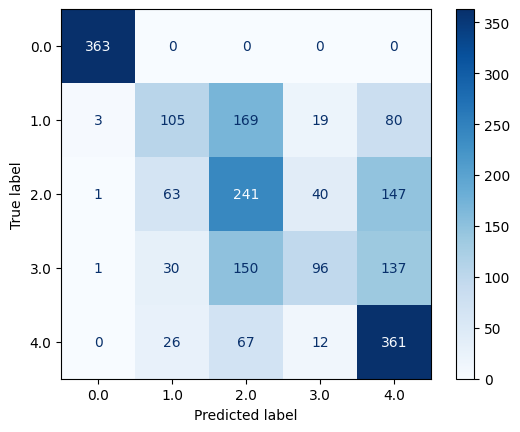

In [60]:
random_forest_pred=random_forest_Pipeline.predict(X_validation)
getMetrics(y_val,random_forest_pred)

In [61]:
best_rate_rf= random_forest_Pipeline.predict(X_test) # Random Forest Best predicted according to the kappa score


In [66]:
df_random_forest= pd.DataFrame(best_rate_rf)


In [68]:
df_random_forest.to_csv('random_forest_prediction_1',index=False)

# Boosting with Best Pipeline

## Explanation for these parameters:

> `subsample`: This paramter helps to define the samples given to the weak learners to create more robust and randomness in the model, ion order prevent overfitting.

>`n_estimators`: To get to know number of boosting stages in the model which is important as in the end voting will take place.

> `max_depth`: I chose this parameter to get the depth of the individual regressor estimators.

>`loss`: to get to know the loss function for the algorithm on which it will converge the best.

> `learning_rate`: to define the convergence speed of the algorithm for the loss function.

In [43]:
Boosting_Pipeline = Pipeline(steps=[
    ('age', AgeConverter()), 
    ("transform", ColumnTransformer(transformers=[
        ('numeric', StandardScaler(), num_col), 
        ('categorical', OneHotEncoder(handle_unknown='ignore'), cat_col),
        ('image', MyImageTransformer(), 'Images'),
        ('text', MyTextTransformer(), 'Description')
    ])),
    ('clf', GradientBoostingClassifier(
        subsample=0.5, 
        n_estimators=200, 
        max_depth=7, 
        loss='log_loss',  
        learning_rate=0.1
    ))  
])
Boosting_Pipeline.fit(X_train_new, np.array(y_train_new).ravel()) 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('age', AgeConverter()),
                ('transform',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Age', 'Fee']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Type', 'Gender', 'Color1',
                                                   'Color2', 'Color3',
                                                   'MaturitySize', 'FurLength',
                                                   'Vaccinated', 'Dewormed',
                                                   'Sterilized', 'Health',
                                                   'Breed']),
                                                 ('image', MyImageTransformer(),
                                                  'Images'),
                                                 ('text', MyTextTransformer(),
                                                  'Description')])),
                ('clf',
                 GradientBoostingClassifier(max_depth=7, n_estimators=200,
                                            subsample=0.5))])

(  Dataset       MSE      Acc     Kappa
 0   Train  1.300332  0.52108  0.669548,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x29f5ea750>)

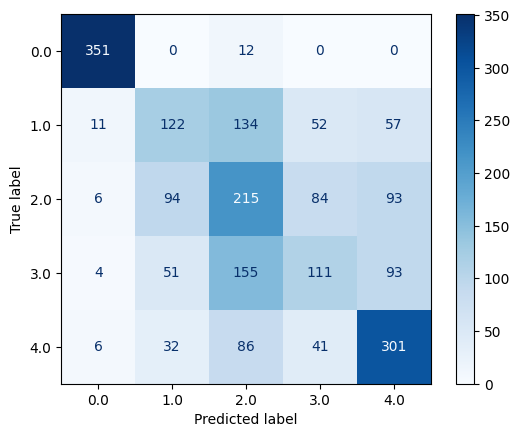

In [47]:
Boosting_pred=Boosting_Pipeline.predict(X_validation)
getMetrics(y_val,Boosting_pred)

In [44]:
best_rate_boosting= Boosting_Pipeline.predict(X_test)

In [45]:
boosting_df= pd.DataFrame(best_rate_boosting)

boosting_df

,0
0,2.0
1,4.0
2,2.0
3,2.0
4,2.0
...,...
495,4.0
496,1.0
497,4.0
498,4.0


In [46]:
boosting_df.to_csv('boosting_predictions',index=False)

# Deep Learning part

In [38]:
num_col = ['Age', 'Fee']
cat_col = ['Type', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Breed']
text_cols = ['Description'] 
img_cols=['Images']

In [39]:
from sklearn.model_selection import train_test_split
X_train_deep, X_val_deep, y_train_deep, y_val_deep = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [40]:
Dl_Pipeline=Pipeline(steps=[
        
        ('age',AgeConverter()), 
        ("transform",ColumnTransformer(transformers=[
            ('numeric',StandardScaler(),num_col),
            ('categorical',OneHotEncoder(handle_unknown='ignore'),cat_col),
            ('image',MyImageTransformer(),'Images'),
            ('text',MyTextTransformer(),'Description')
        ])),

    ])

Dl_Pipeline.fit(X_train_deep) 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('age', AgeConverter()),
                ('transform',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Age', 'Fee']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Type', 'Gender', 'Color1',
                                                   'Color2', 'Color3',
                                                   'MaturitySize', 'FurLength',
                                                   'Vaccinated', 'Dewormed',
                                                   'Sterilized', 'Health',
                                                   'Breed']),
                                                 ('image', MyImageTransformer(),
                                                  'Images'),
                                                 ('text', MyTextTransformer(),
                                                  'Description')]))])

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

y_train_deep = to_categorical(y_train_deep, num_classes=5)  
y_val_deep = to_categorical(y_val_deep, num_classes=5)

X_train_transformed = Dl_Pipeline.transform(X_train_deep)
X_val_transformed = Dl_Pipeline.transform(X_val_deep)

# MLP 

> I used MLP here as by the pipeline my data is already in the numerical form so, according to me CNN or any other approach is not neccessary.

> for penalizing I used L2 regularization.

> Added dropout as well to avoid overfitting.

> Activation function is ReLU

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.callbacks import EarlyStopping



input_shape = X_train_transformed.shape[1]

model = Sequential([
    Input(shape=(input_shape,)),
    # I tried L1 regularization as well but kappa score was really low.
    # I even changed l2 values to [0.1,0.002] again kappa score was very low.
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  
    Dropout(0.3),                                                 
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),  
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),  
    Dropout(0.3),
    # here dense layer dimension is 5 as we have predict among 5 classes  
    Dense(5, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history= model.fit(X_train_transformed, y_train_deep, validation_data=(X_val_transformed, y_val_deep),
          epochs=100,  
          callbacks=[early_stopping])

Epoch 1/100
242/242 [==============================] - 2s 5ms/step - loss: 1.6524 - accuracy: 0.3357 - val_loss: 1.3993 - val_accuracy: 0.4537
Epoch 2/100
242/242 [==============================] - 1s 5ms/step - loss: 1.3817 - accuracy: 0.4658 - val_loss: 1.3262 - val_accuracy: 0.4713
Epoch 3/100
242/242 [==============================] - 1s 5ms/step - loss: 1.2795 - accuracy: 0.5329 - val_loss: 1.3402 - val_accuracy: 0.4904
Epoch 4/100
242/242 [==============================] - 1s 5ms/step - loss: 1.2122 - accuracy: 0.5877 - val_loss: 1.3929 - val_accuracy: 0.5039
Epoch 5/100
242/242 [==============================] - 1s 5ms/step - loss: 1.1558 - accuracy: 0.6453 - val_loss: 1.5120 - val_accuracy: 0.4873
Epoch 6/100
242/242 [==============================] - 1s 5ms/step - loss: 1.0986 - accuracy: 0.6923 - val_loss: 1.5647 - val_accuracy: 0.5059
Epoch 7/100
242/242 [==============================] - 1s 5ms/step - loss: 1.0695 - accuracy: 0.7272 - val_loss: 1.6233 - val_accuracy: 0.5147

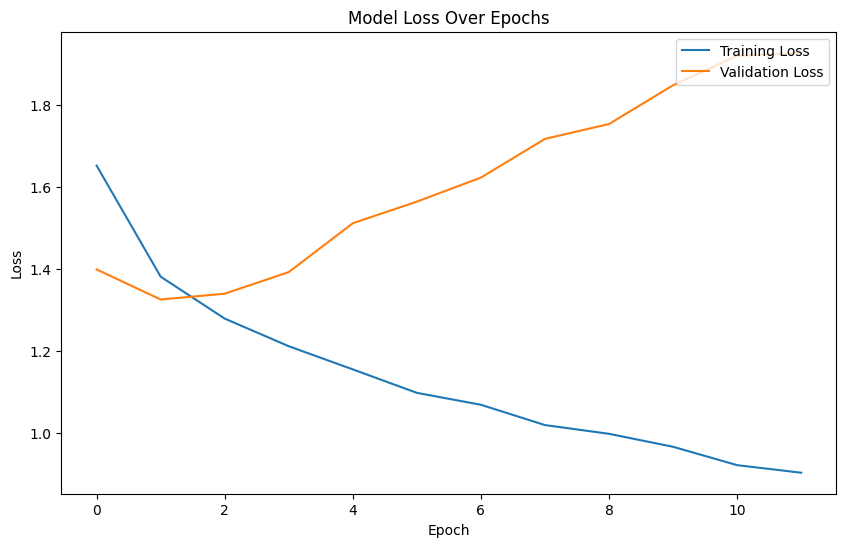

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [45]:
y_pred = model.predict(X_val_transformed)

y_val_labels = np.argmax(y_val_deep, axis=1) #taking argmax as we had list of probabilities from softmax at the last layer.
y_pred_labels = np.argmax(y_pred, axis=1)


kappa_score = cohen_kappa_score(y_val_labels, y_pred_labels)

print(f"Cohen's Kappa Score: {kappa_score}")


61/61 [==============================] - 0s 660us/step
Cohen's Kappa Score: 0.32669210910315416


# Now predicting on Test Set

In [46]:
X_test_transformed= Dl_Pipeline.transform(X_test)

In [47]:
y_test_pred = model.predict(X_test_transformed)  
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

16/16 [==============================] - 0s 1ms/step


In [49]:
y_test_pred_labels

array([2, 2, 2, 4, 2, 1, 3, 2, 2, 2, 4, 2, 2, 4, 2, 4, 2, 2, 2, 4, 2, 2,
       0, 2, 2, 2, 4, 2, 4, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 4, 2, 4, 4,
       2, 2, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 1, 4, 4, 4, 2, 2, 3, 2, 4, 4,
       2, 3, 4, 4, 2, 2, 2, 0, 2, 2, 2, 2, 3, 3, 2, 2, 4, 2, 2, 2, 2, 2,
       2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 4, 2, 2, 2, 4, 4, 4, 3, 2,
       2, 4, 2, 3, 3, 2, 4, 2, 4, 4, 2, 2, 2, 2, 4, 2, 0, 2, 2, 3, 4, 2,
       2, 2, 2, 4, 2, 2, 4, 2, 2, 3, 2, 2, 3, 2, 4, 4, 2, 2, 2, 3, 2, 2,
       2, 2, 2, 3, 3, 4, 2, 2, 4, 3, 4, 2, 2, 4, 4, 2, 4, 3, 4, 2, 4, 2,
       3, 2, 4, 4, 4, 2, 2, 2, 2, 2, 2, 1, 4, 4, 3, 4, 4, 3, 2, 2, 4, 2,
       3, 4, 4, 2, 4, 2, 3, 4, 4, 4, 2, 2, 2, 2, 4, 2, 2, 2, 4, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 3, 2, 3, 2, 4, 2, 2, 3, 2,
       2, 4, 2, 4, 3, 3, 4, 2, 2, 4, 2, 2, 3, 4, 3, 2, 2, 2, 2, 3, 2, 2,
       2, 2, 2, 4, 2, 2, 2, 0, 2, 2, 0, 2, 4, 4, 2, 2, 4, 2, 1, 4, 2, 4,
       4, 2, 3, 2, 2, 4, 2, 2, 4, 4, 2, 4, 4, 2, 3,

In [57]:
y_test_pred_list= y_test_pred_labels.tolist()

df_dl= pd.DataFrame(y_test_pred_list,columns=['prediction rate'])
df_dl['prediction rate']= df_dl['prediction rate'].astype(float) #changing the datatype to float as it was in the original dataset
df_dl

,prediction rate
0,2.0
1,2.0
2,2.0
3,4.0
4,2.0
...,...
495,4.0
496,1.0
497,4.0
498,4.0


In [58]:
df_dl.to_csv('deep_learning_predictions',index=False)